### Тестовое задание №1

**Задача:** 

Выделить из транзакционных данных клиентов, которые покупали кофе/посещали кофейни от 2 раз в месяц хотя бы 2 из 3 месяцев.

Карточные транзакции
- 'customer_id' - идентификатор клиента
- 'card_id' - идентификатор карты клиента
- 'tr_datetime' - дата совершения транзакции
- 'tr_normalized_amount' - сумма транзакции в рублях
- 'currency' - валюта транзакции
- 'mcc' - мсс код транзакции (что такое мсс и поиск значения можно посмотреть тут https://mcc-codes.ru/)
- 'merchant_name' - наименование торговой точки, где была произведена транзакция
- 'merchant_city' - город, в котором была произведена транзакция

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('transactions_small.csv', sep=';', error_bad_lines=False)

display(df.sample(2))
df.info()

,customer_id,card_id,tr_datetime,tr_normalized_amount,currency,mcc,merchant_name,merchant_city
73217,2EC07D3D8760B5A4A37CAD070AED717A,ADAF527C8C497CF78ACD857218931146,2019-10-05,304.0,810,5331,ip kryuchkova e.s. chern ru,zheleznogors
29839,E21DA460F9E27FD50AD650002D613E9C,00DBBCB268492EF449C467AE7A10F538,2019-08-20,223.0,810,5814,restoran kfs nab. chelny ru,nab. chelny


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623956 entries, 0 to 623955
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   customer_id           623956 non-null  object 
 1   card_id               623956 non-null  object 
 2   tr_datetime           623956 non-null  object 
 3   tr_normalized_amount  623956 non-null  float64
 4   currency              623956 non-null  int64  
 5   mcc                   623956 non-null  int64  
 6   merchant_name         623956 non-null  object 
 7   merchant_city         623953 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 38.1+ MB


In [3]:
# Очищаем датасет от нескольких null-записей
df.dropna(inplace=True)
len(df)

623953

#### 1. Дата транзакций

Приводим к общему формату и выделяем день и месяц

In [4]:
df['tr_datetime'] = pd.to_datetime(df.tr_datetime, format='%Y-%m-%d', errors='coerce')

df['tr_month'] = df.tr_datetime.dt.month
df['tr_day'] = df.tr_datetime.dt.day

df.groupby('tr_month')['tr_day'].count()

tr_month
8     204344
9     205319
10    214290
Name: tr_day, dtype: int64

Записи распределены равномерно с небольшим увеличением количества в октябре.

#### 2. MCC код

Данный признак наиболее важен для корректной оценки транзакций. Из открытых источников можно выделить следующие коды, подходящие под описание задачи. 

- **5812** Eating places and Restaurants
- **5814** Fast Food Restaurants

*Скорее, нет:* 
- **5813** Drinking Places (Alcoholic Beverages), Bars, Taverns, Cocktail lounges, Nightclubs and Discotheques 



In [5]:
# Остальные транзакции сейчас не нужны
mcc = [5812, 5814]
df.drop(df[~df['mcc'].isin(mcc)].index, inplace=True)

df.mcc.value_counts(ascending=False)

5814    65522
5812    19288
Name: mcc, dtype: int64

#### 3. Города

Перед тем, как перейти к анализу сумм транзакций, интересно понять, где они совершались

In [6]:
df.merchant_city.nunique()

1056

In [7]:
df.merchant_city.value_counts()[:20]

moscow              26382
saint petersburg     7116
domodedovo           3851
krasnoyarsk          2790
lipetsk              2032
yekaterinburg        1492
nizhny novgorod      1463
novosibirsk          1440
vsevolozhsk          1387
krasnodar            1385
samara               1248
yakutsk              1072
omsk                 1065
ufa                  1031
kazan                1004
tomsk                 910
khabarovsk            904
chelyabinsk           897
perm                  889
ulan-ude              844
Name: merchant_city, dtype: int64

Большая часть - в Москве, в топ-10 так же областные центры + Домодедово и (внезапно) Всеволожск. Данные собраны со всей России.

#### 4. Суммы транзакций

Далее рассмотрим распределение по суммам

In [8]:
df.tr_normalized_amount.describe()

count    84810.000000
mean       427.582099
std       1085.887858
min          0.720000
25%        110.000000
50%        205.000000
75%        396.000000
max      93156.500000
Name: tr_normalized_amount, dtype: float64

**В рамках решаемой задачи более релевантными для нас будут записи в диапазоне от 20 до 3000 руб.** Для последующей обработки оставим в датафрейме только такие транзакции (Однако, этот шаг можно пропустить при желании)

In [9]:
df = df.drop(df[(df.tr_normalized_amount < 20) | (df.tr_normalized_amount > 3000)].index)
df.tr_normalized_amount.describe()

count    82803.000000
mean       340.597528
std        406.901695
min         20.000000
25%        111.000000
50%        204.000000
75%        384.000000
max       3000.000000
Name: tr_normalized_amount, dtype: float64

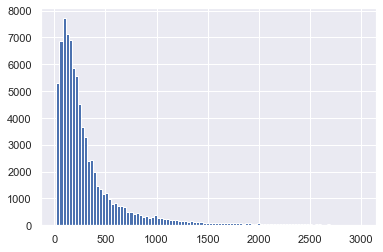

In [10]:
df.tr_normalized_amount.hist(bins=100);

Предсказуемо, что распределение имеет тяжелый правый хвост - в повседневной жизни чаще совершаются микро-покупки, а крупные намного реже. Попробуем логарифмировать эту величину. Делать это необязательно, но пусть будет.

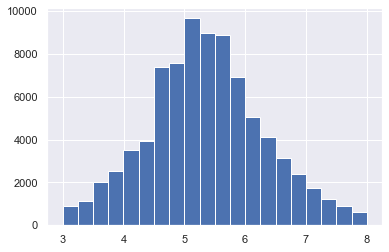

In [11]:
df['log_amount'] = np.log(df['tr_normalized_amount'])
df.log_amount.hist(bins=20);

Теперь данные распределены нормально и в случае необходимости их можно будет использовать для моделирования

#### 5. Валюта

In [12]:
df['currency'].value_counts(ascending=False)

810    81666
978      504
840      104
980       78
949       69
826       61
933       57
410       43
975       36
752       33
348       18
376       17
203       17
985       14
398       14
392       11
51         8
764        8
756        7
704        6
981        5
784        5
944        5
498        5
191        3
946        2
36         2
941        1
8          1
504        1
352        1
788        1
Name: currency, dtype: int64

Так как количество нерублёвых транзакций сравнительно мало, оставим для анализа только операции в руб.

In [13]:
df.drop(df[df['currency'] != 810].index, inplace=True)

#### 6. Название торговой точки

По данному признаку определим, является ли точка продажи кофейней

In [14]:
df.merchant_name.nunique()

17635

Уникальных значений более 17 тыс., поэтому отберём наиболее популярные паттерны названия кофеен. При появлении дополнительной информации список можно будет расширить

In [15]:
df = df[df['merchant_name'].str.\
   contains('cof|kof|starbuck|espresso|cappucc|bodry|shokoladnitsa|doubleb|krispy|donut|upside down|wake')]

# паттерн 'kafe|cafe' пока не добавляю, так как туда попадают не только кофейни, но и обычные забегаловки

display(df.sample(5))
print(len(df))

,customer_id,card_id,tr_datetime,tr_normalized_amount,currency,mcc,merchant_name,merchant_city,tr_month,tr_day,log_amount
210362,6A6E2FB9156BEFF543CA4283CD7865D4,2072C526DE838E54CC3FE9EDE152E8BD,2019-09-09,188.0,810,5814,"""""""starbucks"""" moskva ru""",moscow,9,9,5.236442
227658,A9A78D14672BA9D9015E7712CC28BF79,2DFC7D6C118041F86F5916452831EE2C,2019-09-21,538.0,810,5812,kofeynya ples ru,privolzhsk,9,21,6.287859
614077,2D1B51FBD98FA66F74DA004B8B0C131B,96176515FE651125B7143FA31E364EAD,2019-08-04,320.0,810,5814,kofe-mashina dv khabarovsk ru,khabarovsk,8,4,5.768321
267306,2EE779BFA5EB22515E4BCD8745838606,7015E717BD3BDAA8E8CEDFE41E4726B9,2019-09-18,746.9,810,5812,starbucks coffee korea co seoul kr,seoul,9,18,6.615931
566772,93F38C7E47B0B735397F64A538CF0C8C,5F22D42CBEF499966F407E6B8E293BDA,2019-08-25,670.0,810,5814,starbucks coffee house moskva ru,moscow,8,25,6.507278


5218


В итоге осталось около 5 тыс. транзакций в кофейнях за данный период

#### 7. Решение задачи

In [16]:
# Группируем транзакции помесячно в разрезе клиентов и преобразовываем результат в датафрейм
gr = df.groupby(['tr_month', 'customer_id'])['card_id'].count().reset_index()
gr.columns = ['month', 'customer_id', 'number_of_tr']
gr.sample(4)

,month,customer_id,number_of_tr
400,8,B3DB448056A25A3415AE1D60FB33B06E,3
793,9,62B72DCC87A55C23F8EA8BCFD6087191,1
250,8,6D60C4F7480E107D39801B2B9938B6F9,1
751,9,4DD84A2DC16F923DFFE8CBC992E6AFF2,1


In [17]:
# Нужно оставить только тех клиентов, где количество транзакций в месяц превышает одну:
gr.drop(gr[gr.number_of_tr < 2].index, inplace=True)

# Из них выбираем, где 2 и более покупок были чаще, чем в 1 месяце:
c = gr.customer_id.value_counts()
c[c>1].index

Index(['4F091780FCF1BA18E39338E1E6EDF165', 'BF899F075596112B3FC79A65CA75687B',
       '6015F35ACBB83DE0167C1A34630D3C4C', '0B9C62684D4CB8AD9CC5E2EBE83A265A',
       '7766468FDAE38798C426DB86EEE1A9EC', '63B1AF092136453A467B9298D8F4991C',
       '1A536EF20663AA322D7DAAB19CA7FB75', '3625EC99ED26ECA8F129DA6791A7C31A',
       '47EEF41F98CB930E990D474050C6231F', '116765B446F3A94FDBFC2ED5BB08734D',
       ...
       'ED6C877D049902D51E12652618C1B2AA', 'A1DF041C32B869FE91F34611FDB576EF',
       '249C704E0DC5802979121BCF3A6FD7CC', '13A873ECF427403915BB58EEF5A0D35B',
       '2A1EE63DB31CBDFB5F0979A55290667B', '109C778C526EEE38ABA4A53D36B1FD0F',
       '3D3A4E144753D31F37A5092F81DCFE91', 'B2B26DFD1E7BA76F265E9D2FDDBE9B03',
       '3F90E7183EC47BFD97C34D7C6E14E978', 'C7D94AF34318D50AA4AC79F045AD3A26'],
      dtype='object', length=229)


**Итог:** 

229 клиентов